## This Notebook Explore Time Series Analytics and Predictions

#### USAspending.gov GFY Archive Data Source

In [607]:
# recommend creating a conda env for this to use latest version of Prophet
# it should include install of:
# fbprophet (v.7 or newer), dask, pyarrow, fastparquet, plotly, jupyter, ipyfilechooser, ipywidgets (https://ipywidgets.readthedocs.io/en/stable/user_install.html )

In [608]:
import os, glob, pathlib
import math
import shutil
from datetime import datetime
from collections import Counter
import zipfile
import pandas as pd
import numpy as np
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import psutil
import requests

import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt

# use import below to interactively select the folder where the USAspending Archives are located
# https://pypi.org/project/ipyfilechooser/
from ipyfilechooser import FileChooser
import random

In [609]:
matplotlib.style.use('seaborn')

In [610]:
def Display_System_Info(): # https://psutil.readthedocs.io/en/latest/#psutil.virtual_memory
    physical_cores = psutil.cpu_count(logical=False) #, psutil.cpu_count(logical=True)
    RAM_total_installed = psutil.virtual_memory()[0] #, psutil.swap_memory()
    RAM_available = psutil.virtual_memory().available #['available']
    dask_workers = int(physical_cores/2)
    print(f"Physical CPU Cores: {physical_cores}, RAM available: {round(RAM_available/1e9)} GB, total RAM: {round(RAM_total_installed/1e9)} GB")
    result_record = {'CPU_Cores_Physical' : physical_cores,
                    'RAM_available' : RAM_available,
                     'RAM_total_installed' : RAM_total_installed,
                    }
    return result_record

Display_System_Info()

Physical CPU Cores: 8, RAM available: 33 GB, total RAM: 69 GB


{'CPU_Cores_Physical': 8,
 'RAM_available': 32599928832,
 'RAM_total_installed': 68719476736}

In [611]:
def Get_Current_Time():
    return datetime.now().strftime("%d/%m/%Y %H:%M:%S")

Get_Current_Time()

'23/10/2020 14:01:16'

In [612]:
def CurrentGFY():
    if datetime.now().month >= 10: 
        return datetime.now().year + 1
    else:
        return datetime.now().year
    
def getGFY(datestamp):
    if datestamp.month >= 10: 
        return datestamp.year + 1
    else:
        return datestamp.year
    
def Check_Archive_Filename_Format(filename_complete):
    base_filename = os.path.basename(filename_complete)
    # rule checks
    if not base_filename.startswith("FY"):
        return False
    if not base_filename.endswith(".zip") and not base_filename.endswith(".csv"):
        return False
    if " " in base_filename:
        return False
    if len(base_filename.split(".")) > 2:
        return False
    if "copy" in base_filename:
        return False
    
    return True

def Get_GFY_from_file_path(filename_to_check_complete_path):
    if os.path.isdir(filename_to_check_complete_path):
        #print(f"{filename_to_check_complete_path} is a directory. Ignore")
        return
    filename_GFY = os.path.basename(filename_to_check_complete_path)[:6]
    assert filename_GFY[:2] == 'FY' # check this
    return filename_GFY

def Get_ArchiveDate_from_file_path(filename_to_check_complete_path):
    if os.path.isdir(filename_to_check_complete_path):
        #print(f"{filename_to_check_complete_path} is a directory. Ignore")
        return
    basefilename = os.path.basename(filename_to_check_complete_path)
    if filename_to_check_complete_path.endswith(".zip"):
        filename_latest_update = basefilename.split("_")[4][0:8]
    elif filename_to_check_complete_path.endswith(".csv"):
        filename_latest_update = basefilename.split("_")[4][0:8]
    else:
        filename_latest_update ="Filename_Format_Issue"
    # assert TBD
    return filename_latest_update

In [613]:
# Clean up the Data and add some fields

### function to create a recipient common name using common fields
### addresses problem with multiple versions of names, M&A, and misspellings

#### Please read this link on the USAspending.gov site about use of "D&B Open Data" - https://www.usaspending.gov/db_info
#### "D&B Open Data" is embedded in these records

#TODO - placeholder function - enhance this to find the most common name for the same company in the records 
def Add_Common_Recipient_Names(df): #placeholder for future data validation using a common key(s) or hash value
    # add transformation and validation code to select most common name for an entity-firm-contractor
    df['recipient_parent_name_common'] = df['recipient_parent_name']
    df['recipient_name_common'] = df['recipient_name']
    return

# !!! possible use in the future cage_codes are missing for most records prior to GFY19
# def Add_Common_Recipient_Names_Using_CAGE_Code(df): #works ok starting in FY19 (missing from ~200M $s in GFY19) but is unreliable prior to that - missing
#     # Build cage_code to recipient_parent_name, recipient_name mapping and collect the most common names
#     # There are naming inconsistencies in the USAspending.gov data for recipient_names
#     # Create code to build a unique identifier that can be used in groupby for recipient_parent_name when there are spelling and naming inconsistencies

#     cage_name_mapping = df[['action_date_fiscal_year','cage_code','recipient_parent_name', 'recipient_name']].drop_duplicates()
#     #cage_name_mapping.shape

#     #TODO add code to properyly handle how the recipient_parent_name and the recipient_name may change across GFY
#     # get the most common recipient_name for each cage_code
#     cage_name_mapping_recipient_parent = cage_name_mapping.groupby(['cage_code'])['recipient_parent_name'].apply(list).apply(Counter).apply(lambda x: x.most_common()[0][0])
#     cage_name_mapping_recipient = cage_name_mapping.groupby(['cage_code'])['recipient_name'].apply(list).apply(Counter).apply(lambda x: x.most_common()[0][0])

#     #cage_name_mapping_recipient_parent['00026'] # assert in FY2019 == 'MMC INTERNATIONAL CORP.'

#     # add a column with the most common recipient_name for downstream groupby actions
#     df['recipient_parent_name_common'] = df['cage_code'].apply(lambda x: cage_name_mapping_recipient_parent[x])
#     df['recipient_name_common'] = df['cage_code'].apply(lambda x: cage_name_mapping_recipient[x])    
#     return df

def Fix_Recipient_Name_UNSPECIFIED(df):
    #fix blank or UNSPECIFIED recipient_parent_names
    
#     fix_UNSPECIFIED_lambda = lambda x: x['recipient_name'] + "_UNSPECIFIED" if x['recipient_parent_name'] in ['', 'UNSPECIFIED'] else x['recipient_parent_name']
#     #pandas.core.frame.DataFrame, dask.dataframe.core.DataFrame
#     if type(df) == dask.dataframe.core.DataFrame:
#         df['recipient_parent_name'] = df.apply(fix_UNSPECIFIED_lambda, axis = 1, meta=('recipient_parent_name', 'object'))
#     else:
#         df['recipient_parent_name'] = df.apply(fix_UNSPECIFIED_lambda, axis = 1)
    
    df['recipient_parent_name'] = df['recipient_parent_name'].mask(df['recipient_parent_name'] == 'UNSPECIFIED', df['recipient_parent_name'] + "_UNSPECIFIED") # use of mask instead of other options - https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.mask

    return

def Fix_Recipient_Names_Known_Issues(df): # MANUAL Fixes needed due to USAspending.gov not updating recipient_parent_name (e.g., after SAIC spun out Leidos)
    #TODO - shoould be added at time of read of the files as part of prep
    
    #fix Naming Issues - Manual Fixes (large firms mostly - edit the external files)
    
    if glob.glob("USAspending_Parent_Name_Fixes_Manual.csv"):
        df_fixes = pd.read_csv("USAspending_Parent_Name_Fixes_Manual.csv")
        manual_fixes_lookup = {}
        for index, row in df_fixes.iterrows():
            manual_fixes_lookup[row['recipient_old_name']] = {'recipient_new_name' :row['recipient_new_name'],
                                                              'GFY_When_Switch_Happens' : row['GFY_When_Switch_Happens'],
                                                             }
    
    else:
        manual_fixes_lookup = {
            'SAIC' : {'recipient_new_name' : 'LEIDOS HOLDINGS  INC.',
                                                               'GFY_When_Switch_Happens' : '2014'}, #!!Notes ther is an extra space needed between HOLDINGS and Inc. name in USAspending, common name fix
            'SAIC  INC.' : {'recipient_new_name' : 'LEIDOS HOLDINGS  INC.',
                                                               'GFY_When_Switch_Happens' : '2014'},
            'NORTHROP GRUMMAN SYSTEMS CORPORATION' : {'recipient_new_name' : 'NORTHROP GRUMMAN CORPORATION',
                                                      'GFY_When_Switch_Happens' : ''
                                                     },

        }
    
    for old_name, new_name_record in manual_fixes_lookup.items():
        new_name = new_name_record['recipient_new_name']
        GFY_When_Switch_Happens = new_name_record['GFY_When_Switch_Happens']
        # mask preferred via https://stackoverflow.com/questions/54360549/dask-item-assignment-cannot-use-loc-for-item-assignment
        
        if not math.isnan(GFY_When_Switch_Happens) and GFY_When_Switch_Happens != '':
            selector = (df['recipient_parent_name'] == old_name) & (df['action_date_fiscal_year'].astype('int64') >= int(GFY_When_Switch_Happens))
        else:
            selector = (df['recipient_parent_name'] == old_name)
        
        df['recipient_parent_name'] = df['recipient_parent_name'].mask(selector, new_name) # use of mask instead of other options - https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.mask
        
    return

def Add_PSC_Cat_Fields(df):
    print(f"{Get_Current_Time()} -> adding PSC_Cat field...")
    df['PSC_Cat'] = df['product_or_service_code'].str[:1]
    df['PSC_Cat_2'] = df['product_or_service_code'].str[:2]
    return

def Fix_High_Compensated_Field(df):
    # these fields were read in via pandas as strings (pandas objects), need to convert them to float
    # some of the fields contain text inside of values and some had NaN that was repalced with UNSPECIFIED
    fields_for_float =[
        'highly_compensated_officer_1_amount',
           'highly_compensated_officer_2_amount',
           'highly_compensated_officer_3_amount',
           'highly_compensated_officer_4_amount',
           'highly_compensated_officer_5_amount'
    ]


    for field in fields_for_float:
        df[field] = df[field].apply(lambda x: float(x) if x.replace(".","").isdigit() else 0.0)
    return
    

def Enhance_Spending_File(df): # this function addresses known shortcomings in the USAspending archive data
    print()
    print(f"{Get_Current_Time()} -> replacing NaN with UNSPECIFIED...")
    df = df.fillna("UNSPECIFIED") # IMPORTANT - NA fields can affect groupby sums and other problems
    
    if 'product_or_service_code' in df.columns:
        Add_PSC_Cat_Fields(df)
    
    print(f"{Get_Current_Time()} -> fixing missing recipient_parent_name...")
    Fix_Recipient_Name_UNSPECIFIED(df)
    print(f"{Get_Current_Time()} -> fixing recipient_parent_names that are inconsistent...")
    Fix_Recipient_Names_Known_Issues(df)
    
    #print(f"{Get_Current_Time()} -> adding recipient_name_common and recipient_parent_name_common fields for groupby")
    #Add_Common_Recipient_Names(df)
    
    if 'highly_compensated' in df.columns:
        print(f"{Get_Current_Time()} -> converting highly_compensated field amounts to float")
        Fix_High_Compensated_Field(df)
    
    print(f"{Get_Current_Time()} Done with fixes.")
    print()
    return df

In [614]:
## Key code for read CSV files into pandas and Dask
def Build_DTypes_Dict(filename_list):
    df = pd.read_csv(filename_list[0], nrows=1)
    
    dtype = dict(zip(sorted(df.columns), ['object'] * len(df.columns)))
    
    # ! important - may need to change other fields to category, int, date etc for better memory management
    dtype['federal_action_obligation'] = 'float64'
    #dtype['action_date_fiscal_year'] = 'int'
    
    return dtype

def Load_CSV_Files_Into_DF(filename_list, usecols = 'ALL'): #best approach if you have enough RAM memory on your machine
    
    dtype = Build_DTypes_Dict(filename_list) # ! important - may need to change other fields to category, int, date etc for better memory management
    
#     print(f"Reading file: {filename_list[0]}")
#     df = pd.read_csv(filename_list[0], dtype=dtype, low_memory=False) # read the first file
    
#     for filename in filename_list[1:]: #read the remaining files and append
#         print(f"Reading file: {filename}")
#         df = df.append(pd.read_csv(filename, dtype=dtype, low_memory=False))
        
    #alternative approach - faster?
    dataframe_loads_list = []
    for filename in filename_list:
        print(f"Reading file: {os.path.basename(filename)}")
        if usecols == 'ALL':
            dataframe_loads_list.append(pd.read_csv(filename, dtype=dtype, low_memory=False))
        else:
            dataframe_loads_list.append(pd.read_csv(filename, dtype=dtype, usecols = usecols, low_memory=False))
    df = pd.concat(dataframe_loads_list)
    print("Files loaded into pandas dataframe.")
    return df

In [615]:
# this assumes the jupyter notebook is running in the same higher level directory
# where the USAspending.gov zip archives and the decompressed Zip files are stored

original_cwd = os.getcwd() # use this if  files are located in local directory where jupyter is running
# 
folder_choice = FileChooser(os.getcwd(),
                           title='<b>Choose Folder with USAspending.gov GFY Archive Expanded CSV Files:</b>',
                            show_hidden=False,
                            select_default=True,
                            use_dir_icons=True,
                            show_only_dirs=True)
display(folder_choice)

FileChooser(path='/Users/leifulstrup/Documents/Primehook/Marketing/Medium Blog Posts', filename='', title='HTM…

In [619]:
download_file_path_CSV = str(folder_choice.selected_path)

your_path_dummy = 'Users/YourName/YourTopFolder_Documents/YourUSAspendingFolderName'
#print(original_cwd)
print(os.path.join(your_path_dummy, "/".join(download_file_path_CSV.split('/')[-2:])))

Users/YourName/YourTopFolder_Documents/YourUSAspendingFolderName/USAspending_Archive_Downloads/Expanded_CSV_Files


In [620]:
# do a quick check to make sure the CSV files are there
csv_files_list = sorted(glob.glob(os.path.join(download_file_path_CSV, "*.csv")))

gfy_list = set()
size_of_files_GB = 0
for n, filename in enumerate(csv_files_list):
    filename_basename = os.path.basename(filename)
    print(n+1, filename_basename)
    gfy_list.add(filename_basename[:6])
    size_of_files_GB += os.path.getsize(filename)

all_GFY_list = sorted(set([Get_GFY_from_file_path(filename) for filename in csv_files_list]))
    
print()
print(f"There are {len(csv_files_list)} CSV files. They use {round(size_of_files_GB/1e9, 3)} GB of storage.")
print(f"Covering GFY: {sorted(gfy_list)}")
print(f"Current GFY: {'FY' + str(CurrentGFY())}")
print()

1 FY2010_All_Contracts_Full_20200807_1.csv
2 FY2010_All_Contracts_Full_20200807_2.csv
3 FY2010_All_Contracts_Full_20200807_3.csv
4 FY2010_All_Contracts_Full_20200807_4.csv
5 FY2011_All_Contracts_Full_20200807_1.csv
6 FY2011_All_Contracts_Full_20200807_2.csv
7 FY2011_All_Contracts_Full_20200807_3.csv
8 FY2011_All_Contracts_Full_20200807_4.csv
9 FY2012_All_Contracts_Full_20200807_1.csv
10 FY2012_All_Contracts_Full_20200807_2.csv
11 FY2012_All_Contracts_Full_20200807_3.csv
12 FY2012_All_Contracts_Full_20200807_4.csv
13 FY2013_All_Contracts_Full_20200807_1.csv
14 FY2013_All_Contracts_Full_20200807_2.csv
15 FY2013_All_Contracts_Full_20200807_3.csv
16 FY2014_All_Contracts_Full_20200808_1.csv
17 FY2014_All_Contracts_Full_20200808_2.csv
18 FY2014_All_Contracts_Full_20200808_3.csv
19 FY2015_All_Contracts_Full_20200808_1.csv
20 FY2015_All_Contracts_Full_20200808_2.csv
21 FY2015_All_Contracts_Full_20200808_3.csv
22 FY2015_All_Contracts_Full_20200808_4.csv
23 FY2015_All_Contracts_Full_20200808_5.c

In [621]:
## Load GFY2010-GFY2019 with limited Columns even though we will mostly use GFY19 (demonstrate usecols feature)

# You can limit the selection to a subset of the GFY to speed processing

ALL_GFY = False # switch to True to override the subset

user_select_GFY = ['FY2020','FY2019', 'FY2018', 'FY2017', 'FY2016', 'FY2015', 'FY2014', 'FY2013', 'FY2012', 'FY2011', 'FY2010']

if ALL_GFY:
    user_select_GFY = all_GFY_list
    
# print(f"GFY to read for analysis: {sorted(user_select_GFY)}")
# print()

# Create csv_files_list_restricted to streamline downstream data processing

csv_files_list = sorted(glob.glob(os.path.join(download_file_path_CSV, "*.csv")))
csv_files_list_restricted = [filename for filename in csv_files_list for GFY in user_select_GFY if GFY in filename]
gfy_found_in_files = [Get_GFY_from_file_path(filename) for filename in csv_files_list_restricted]
csv_GFY_missing = sorted(set(user_select_GFY) - set(gfy_found_in_files))

assert set(user_select_GFY) == set(user_select_GFY) # check to make sure this is working

print(f"You have selected these GFY for analysis:{user_select_GFY}")
print(f"Missing GFY: {csv_GFY_missing} -> if GFY missing, confirm you have decompressed the GFY zip file archive")

#[(os.path.basename(filename), round(os.path.getsize(filename)/1e9, 3)) for filename in csv_files_list_restricted]

You have selected these GFY for analysis:['FY2020', 'FY2019', 'FY2018', 'FY2017', 'FY2016', 'FY2015', 'FY2014', 'FY2013', 'FY2012', 'FY2011', 'FY2010']
Missing GFY: [] -> if GFY missing, confirm you have decompressed the GFY zip file archive


### Select a subset of fields we will use for forecasting

In [622]:
%%time

dtype = Build_DTypes_Dict(csv_files_list_restricted) # this handles reduces ambiguity for dask interpreting data type to infer on read

### Since we only need a few fields from the ~280 fields, we can radically reduce the memory needed and use pandas

fields = sorted(dtype.keys())

CPU times: user 26.4 ms, sys: 7.63 ms, total: 34 ms
Wall time: 31.1 ms


In [623]:
#fields

In [624]:
# we do not need all of the 280+ fields from the records
# usecols = in pd.read_csv and Dask allows one to be selective on the fields and save memory

usecols = ['action_date',
           'action_date_fiscal_year',
           'recipient_parent_name',
           'recipient_name',
           'federal_action_obligation',
           'funding_agency_name',
           'funding_sub_agency_name',
           'funding_office_name',
           'product_or_service_code_description',
           'product_or_service_code',
          ]

In [625]:
%%time

USAspending_parquet_file_name = "USAspending_GFY2010_GFY2020ytd_Time_Series_Analytics.parquet"

if glob.glob(USAspending_parquet_file_name): #if this file read has already happened, read from parquet file
    print(f"Reading parquet file: {USAspending_parquet_file_name} instead of CSV file sources.")
    df = pd.read_parquet(USAspending_parquet_file_name)
else:
    df = Load_CSV_Files_Into_DF(csv_files_list_restricted, usecols = usecols)
    df = Enhance_Spending_File(df)
    # Save the data in a parquet file to restart below if needed
    print(f"Saving the data to a parquet file: {USAspending_parquet_file_name} in local directory.")
    df.to_parquet(USAspending_parquet_file_name)

df = df.reset_index(drop=True) # creating a new index is key here for later index searches - duplicates otherwise

df.head()

Reading parquet file: USAspending_GFY2010_GFY2020ytd_Time_Series_Analytics.parquet instead of CSV file sources.
CPU times: user 48.7 s, sys: 21.9 s, total: 1min 10s
Wall time: 1min 6s


,federal_action_obligation,action_date,action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,funding_office_name,recipient_name,recipient_parent_name,product_or_service_code,product_or_service_code_description,PSC_Cat,PSC_Cat_2
0,0.00,2009-12-15,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W1YN USA MANPOWER ANALYSIS AGY,BOOZ ALLEN HAMILTON INC.,BOOZ ALLEN HAMILTON HOLDING CORPORATION,R499,OTHER PROFESSIONAL SERVICES,R,R4
1,0.00,2010-04-16,2010,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,ALLSTEEL INC.,HNI CORPORATION,7110,OFFICE FURNITURE,7,71
2,840000.00,2009-12-09,2010,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION ...,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION,GODDARD SPACE FLIGHT CENTER,THE PENNSYLVANIA STATE UNIVERS,"PENNSYLVANIA STATE UNIVERSITY, THE",AR21,R&D-SPACE SCIENCE & APPL-B RES,A,AR
3,186174.39,2009-12-29,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W1YN USA MANPOWER ANALYSIS AGY,BOOZ ALLEN HAMILTON INC.,BOOZ ALLEN HAMILTON HOLDING CORPORATION,R499,OTHER PROFESSIONAL SERVICES,R,R4
4,0.00,2010-09-15,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE NAVY,NAVSUP WEAPON SYSTEMS SUPPORT MECH,VELAN INC,SOCIETE HOLDING VELAN LTEE,4820,"VALVES, NONPOWERED",4,48


In [626]:
df.columns

Index(['federal_action_obligation', 'action_date', 'action_date_fiscal_year',
       'funding_agency_name', 'funding_sub_agency_name', 'funding_office_name',
       'recipient_name', 'recipient_parent_name', 'product_or_service_code',
       'product_or_service_code_description', 'PSC_Cat', 'PSC_Cat_2'],
      dtype='object')

In [627]:
df.shape, len(set(df.index)) #confirm we have created unique index values

((46118584, 12), 46118584)

In [628]:
print(f"There are ~{int(df.shape[0]/1e6)} million transactions in the dataset.")

There are ~46 million transactions in the dataset.


In [629]:
print(f"pandas DataFrame memory usage: ~{round(df.memory_usage().sum()/1e9,1)} GB")

pandas DataFrame memory usage: ~4.4 GB


In [630]:
%time
### If you launch Dask computations but want to stop it, select the square jupyter button "interrupt the kernel"

##This can be used as a QC check to make sure the GFY requested were read
##this is a slow computation since Dask must read every record in all of the files
# action_date_fiscal_yearS = set(sorted(ddf['action_date_fiscal_year'].unique()))
# assert action_date_fiscal_yearS == user_select_GFY

# Without the command .compute() at the end of the next statement, Dask adds the task to a graph of operations.
# when Dask encounters a .compute(), the preceding graph operations are performed

df_GFY_obligations = df.groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().reset_index()

# You can check the computations against these articles:
# https://about.bgov.com/news/federal-contract-spending-five-trends-in-five-charts/
df_GFY_obligations

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs


,action_date_fiscal_year,federal_action_obligation
0,2010,5.610369e+11
1,2011,5.398079e+11
2,2012,5.208065e+11
3,2013,4.633853e+11
4,2014,4.461897e+11
5,2015,4.397271e+11
6,2016,4.754231e+11
7,2017,5.105917e+11
8,2018,5.553379e+11
9,2019,5.898982e+11


<AxesSubplot:title={'center':'Federal Contractor Obligations $s'}, xlabel='action_date_fiscal_year'>

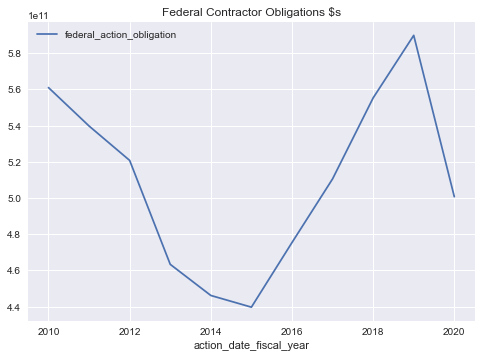

In [631]:
df_GFY_obligations.plot(x='action_date_fiscal_year', y='federal_action_obligation',title="Federal Contractor Obligations $s",grid=True)

## Time Series Analytics

In [632]:
# Facebook's Prophet Time Series Analytics Tool
# https://facebook.github.io/prophet/docs/installation.html#python
# https://peerj.com/preprints/3190/

# installing facebook Prophet - https://facebook.github.io/prophet/docs/installation.html#python

In [633]:
# video on Prophet - https://youtu.be/pOYAXv15r3A 
# explanations of the models that power Prophet - 
# https://medium.com/future-vision/the-math-of-prophet-46864fa9c55a
# https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274
# Bayesian inferencing tool behind Prophet - https://pystan.readthedocs.io/en/latest/
# examples - https://xang1234.github.io/prophet/ (explores several features advanced)
# https://pbpython.com/prophet-overview.html  # Business Python website
# https://nextjournal.com/viebel/forecasting-time-series-data-with-prophet
# https://juanitorduz.github.io/fb_prophet/

In [634]:
#! conda install -c conda-forge fbprophet
# OR
#! pip install fbprophet

In [635]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot

from datetime import date
import holidays

In [636]:
!conda list | grep fbprophet #get version number of the FB Prophet package

fbprophet                 0.7.1            py38h11c0d25_0    conda-forge


In [637]:
import importlib
try:
    package_spec = importlib.util.find_spec("dask")
    DASK_INSTALLED = package_spec is not None
except ImportError as e:
    DASK_INSTALLED = False  # module doesn't exist, deal with it.
    
print(f"dask_installed: {DASK_INSTALLED}")

dask_installed: True


/Users/leifulstrup/opt/anaconda3/envs/FB_Prophet_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


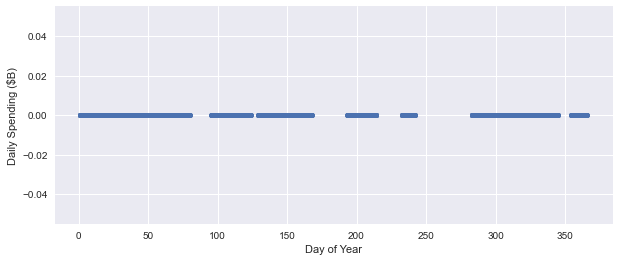

In [638]:
# Collect helper functions

def Get_US_Holdays_df(start_year = 2010, end_year = 2025):
    holiday_list = []
    for date, name in sorted(holidays.US(years=range(start_year,end_year+1)).items()):
        #print(date, name)
        holiday_list.append({'ds' : date, 'holiday' : name})
    df_holidays = pd.DataFrame(holiday_list)
    return df_holidays

df_holidays = Get_US_Holdays_df()
#df_holidays

def Select_Within_Date_Range(df, start_date='2010-1001', end_date='2022-09-30'):
    pass
    return df

def plot_yearly_component_with_exp(forecast):
    df_plot = forecast[['ds', 'yearly']].copy()
    df_plot['ds'] = pd.to_datetime(df_plot['ds'])
    df_plot['yearly_exp'] = np.exp(df_plot['yearly'])
    df_plot['day_of_year'] = df_plot['ds'].apply(lambda x: x.timetuple().tm_yday)
    figure = df_plot.plot.scatter(x='day_of_year', y='yearly_exp', figsize=(10,4),linestyle='solid')
    figure.set_xlabel("Day of Year")
    figure.set_ylabel("Daily Spending ($B)")
    return figure

plot_yearly_component_with_exp(forecast)

def Prepare_df_USAspending_for_Prophet(df):
    
    df_return = df.groupby(['action_date'])['federal_action_obligation'].sum().reset_index()
    
    df_return.columns = ['ds', 'y']
    
    # Should y be converted into a natural log value via np.log() and then expanded via np.exp()?
    # This suggests that converted the values to ln improves forecasting with data that has a wide range - https://people.duke.edu/~rnau/411log.htm
    # See Prof Robert Nau, Fuqua School of Business, Duke University - "Statistical Forecasting - regression and time series" - https://people.duke.edu/~rnau/411home.htm
    df_return['y'] = np.log(df_return['y']) # transform to natural log
    
    return df_return

#Prepare_df_USAspending_for_Prophet(df[df['action_date_fiscal_year'] != '2020'])

def Build_Prophet_Model_forecast(df_daily_total_obligations, predict_days_in_the_future = (365 * 2)):
    df_holidays = Get_US_Holdays_df()
    model_Prophet = Prophet(growth='linear', holidays = df_holidays, ) #, changepoint_prior_scale=0.5, seasonality_mode='multiplicative') # create an instance of the Prophet class
    model_Prophet.add_country_holidays(country_name = 'US')
    model_Prophet.fit(df_daily_total_obligations) # send the data to the model you created to fit the data
    future = model_Prophet.make_future_dataframe(periods = predict_days_in_the_future) # 2 year forecast
    forecast = model_Prophet.predict(future)
    return model_Prophet, forecast

def Plot_Prophet_Model(model_Prophet, forecast):
    
    # this code from this example https://github.com/facebook/prophet/issues/1495
    model_Prophet.history['y'] = np.exp(model_Prophet.history['y'])
    cols = ['yhat_lower', 'yhat_upper', 'yhat']
    forecast[cols] = forecast[cols].transform(np.exp) # use np.exp since y values were converted to np.log in Prepare_df_USAspending_for_Prophet(df)
       
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
    
    figure_1 = model_Prophet.plot(forecast)
    add_changepoints_to_plot(figure_1.gca(), model_Prophet ,forecast)
    
    figure_2 = model_Prophet.plot_components(forecast) # use forecast here so these are not muted due to np.log
                          
    return figure_1, figure_2

#### There are data entry error transactions in USAspending that should be removed.
Some are very large. Including them distorts the projections and plots.

In [639]:
%%time
df_sorted = df.sort_values(by='federal_action_obligation', ascending=False)

CPU times: user 1min 11s, sys: 9.56 s, total: 1min 21s
Wall time: 1min 21s


In [640]:
# # Example of extreme cases

# df_sorted.head()

# df_sorted.tail()

# df.groupby(['action_date_fiscal_year']).agg({'federal_action_obligation' : [np.mean, np.max, np.min]})

In [641]:
%%time

# aggregate spending by GFY/Dept/Agency/Office to look for max and min amounts that are likley in error
# compute obligation sum, mean, max, min to find cases where max and min are multiples of sum
df_sorted_agg = df_sorted.groupby(['action_date_fiscal_year', 'funding_agency_name', 'funding_sub_agency_name', 'funding_office_name']).agg({'federal_action_obligation' : [np.sum, np.max, np.min, np.mean]}).reset_index()
df_sorted_agg.columns = [value1 if value2 == '' else value1+'_'+value2 for value1, value2 in df_sorted_agg.columns]
df_sorted_agg['max_fraction_of_sum'] = df_sorted_agg['federal_action_obligation_amax']/df_sorted_agg['federal_action_obligation_sum']
df_sorted_agg

CPU times: user 18.4 s, sys: 2.33 s, total: 20.8 s
Wall time: 19.2 s


,action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,funding_office_name,federal_action_obligation_sum,federal_action_obligation_amax,federal_action_obligation_amin,federal_action_obligation_mean,max_fraction_of_sum
0,2010,ACCESS BOARD (USAB),ARCHITECTURAL AND TRANSPORTATION BARRIERS COMP...,ARCHITECTURAL AND TRANSPORTATION BARRIERS COMP...,5.629660e+05,6.000000e+04,-15428.86,8278.911912,0.106578
1,2010,ACCESS BOARD (USAB),ARCHITECTURAL AND TRANSPORTATION BARRIERS COMP...,UNSPECIFIED,1.990186e+05,4.604958e+04,-2300.00,9477.075714,0.231383
2,2010,ADVISORY COUNCIL ON HISTORIC PRESERVATION (ACHP),ADVISORY COUNCIL ON HISTORIC PRESERVATION,ADVISORY COUNCIL ON HISTORIC PRESERVATION,4.233528e+05,2.376000e+05,-3116.25,60478.977143,0.561234
3,2010,AFRICAN DEVELOPMENT FOUNDATION (EOP),AFRICAN DEVELOPMENT FOUNDATION,AFRICAN DEVELOPMENT FOUNDATION,0.000000e+00,0.000000e+00,0.00,0.000000,NaN
4,2010,AGENCY FOR INTERNATIONAL DEVELOPMENT (USAID),AGENCY FOR INTERNATIONAL DEVELOPMENT,AGENCY FOR INTERNATIONAL DEVELOPMENT,4.888438e+09,2.015680e+08,-15500000.00,661404.153711,0.041234
...,...,...,...,...,...,...,...,...,...
212260,2020,UNSPECIFIED,FEDERAL PERMITTING IMPROVEMENT STEERING COUNCIL,FPISC,1.753954e+05,1.753954e+05,0.00,87697.710000,1.000000
212261,2020,UNSPECIFIED,UNITED STATES INTERNATIONAL DEVELOPMENT FINANC...,OFFICE OF ACQUISITION,2.428946e+06,9.500000e+05,-96324.07,51679.692340,0.391116
212262,2020,UNSPECIFIED,UNITED STATES INTERNATIONAL DEVELOPMENT FINANC...,USIDFC,4.099900e+04,4.099900e+04,0.00,10249.750000,1.000000
212263,2020,UNSPECIFIED,"USDA, OFFICE OF THE CHIEF FINANCIAL OFFICER","USDA, OCFO",9.967463e+07,1.299291e+07,-623137.21,334478.619228,0.130353


#### Examine transactions that are many times larger or smaller than the sum for the GFY
Are these typos or data validation errors? Many see to be backed out with negative transactions that are close but not equal.

In [642]:
# Step 1: Identify funding offices with imbalanced transactions much greater or smaller than annual sum of obligations
selector = (df_sorted_agg['max_fraction_of_sum'] > 1.5) & \
(df_sorted_agg['federal_action_obligation_amax'] > 100e6) & \
(~df_sorted_agg['max_fraction_of_sum'].isin([np.inf])) 
df_extreme_transactions = df_sorted_agg[selector].sort_values(by=['max_fraction_of_sum'], ascending=[False]) #.head(30)
df_extreme_transactions

,action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,funding_office_name,federal_action_obligation_sum,federal_action_obligation_amax,federal_action_obligation_amin,federal_action_obligation_mean,max_fraction_of_sum
26894,2011,DEPARTMENT OF DEFENSE (DOD),DEPT OF DEFENSE,HOOD EXECUTIVE EM OFFICE 1011320,1.588770e+05,1.612266e+08,-1.612266e+08,1.985962e+04,1014.789013
110261,2014,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE NAVY,NAVOPSPTCEN WHDBY ISLAND,3.217340e+05,1.743353e+08,-1.743353e+08,2.924855e+04,541.861408
88211,2013,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W2SD FEST NAU1 EUROPE,6.865059e+08,3.447339e+11,-3.447337e+11,3.518739e+05,502.157239
125644,2015,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W2SD ENDIST BALTIMORE,7.939203e+08,9.249072e+10,-9.249016e+10,2.943716e+05,116.498744
24972,2010,GENERAL SERVICES ADMINISTRATION (GSA),FEDERAL ACQUISITION SERVICE,GSA/FTS TELECOM SERVICES DIVISON,2.319379e+06,1.056000e+08,-1.051098e+08,5.657021e+04,45.529433
125023,2015,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W072 ENDIST LOUISVILLE,3.515439e+08,1.068477e+10,-1.068476e+10,2.484409e+05,30.393843
140198,2016,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE AIR FORCE,HQ USSOCOM SOAL T,7.946492e+06,2.128686e+08,-2.128686e+08,4.966557e+05,26.787743
88922,2013,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W6GZ ELE RCC BAGRAM,3.925652e+07,6.691753e+08,-6.638001e+08,2.892890e+04,17.046220
147146,2016,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),HEALTH RESOURCES AND SERVICES ADMINISTRATION,OFFICE OF THE ADMINISTRATOR,1.971553e+07,1.698014e+08,-1.698014e+08,2.355499e+04,8.612574
125656,2015,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W2SN ENDIST FAR EAST,2.344297e+08,1.980860e+09,-1.980810e+09,4.823656e+05,8.449697


In [643]:
print(f"There are {df_extreme_transactions.shape[0]} transactions over the GFY that are > 100M and multiples of annual obligation total.")

There are 17 transactions over the GFY that are > 100M and multiples of annual obligation total.


In [644]:
%%time
# Step 2: For the above cases, remove the high and low value transactions from the master list
#TODO figure out a much faster algorithm to identify these transactions - this method is very slow
index_to_exclude = []

for n in range(df_extreme_transactions.shape[0]):
    #df_extreme_transactions.iloc[n]
    GFY = df_extreme_transactions.iloc[n]['action_date_fiscal_year']
    funding_agency_name = df_extreme_transactions.iloc[n]['funding_agency_name']
    funding_sub_agency_name = df_extreme_transactions.iloc[n]['funding_sub_agency_name']
    funding_office_name = df_extreme_transactions.iloc[n]['funding_office_name']
    amount_max = df_extreme_transactions.iloc[n]['federal_action_obligation_amax']
    amount_min = df_extreme_transactions.iloc[n]['federal_action_obligation_amin']

    selector = (df['action_date_fiscal_year'] == GFY) \
    & (df['funding_agency_name'] == funding_agency_name) \
    & (df['funding_sub_agency_name'] == funding_sub_agency_name) \
    & (df['funding_office_name'] == funding_office_name) \
    #& (df['federal_action_obligation'] == amount_max) \
    #& & (df['federal_action_obligation'] == amount_min)
    index_to_exclude.append(df[selector & (df['federal_action_obligation'] == amount_max)].index[0])
    index_to_exclude.append(df[selector & (df['federal_action_obligation'] == amount_min)].index[0])


#index_to_exclude

df.iloc[index_to_exclude]

CPU times: user 2min 21s, sys: 4.14 s, total: 2min 25s
Wall time: 2min 22s


,federal_action_obligation,action_date,action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,funding_office_name,recipient_name,recipient_parent_name,product_or_service_code,product_or_service_code_description,PSC_Cat,PSC_Cat_2
6504875,1.612266e+08,2010-11-23,2011,DEPARTMENT OF DEFENSE (DOD),DEPT OF DEFENSE,HOOD EXECUTIVE EM OFFICE 1011320,BALFOUR BEATTY/MCCARTHY A JOINT VENTURE,BALFOUR BEATTY/MCCARTHY A JOINT VENTURE,Y141,CONSTRUCT/HOSPITALS & INFIRMARIES,Y,Y1
6504884,-1.612266e+08,2010-11-23,2011,DEPARTMENT OF DEFENSE (DOD),DEPT OF DEFENSE,HOOD EXECUTIVE EM OFFICE 1011320,BALFOUR BEATTY/MCCARTHY A JOINT VENTURE,BALFOUR BEATTY/MCCARTHY A JOINT VENTURE,Y141,CONSTRUCT/HOSPITALS & INFIRMARIES,Y,Y1
15080549,1.743353e+08,2013-10-01,2014,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE NAVY,NAVOPSPTCEN WHDBY ISLAND,"WOLF CREEK FEDERAL SERVICES, INC.",CHUGACH ALASKA CORPORATION,S216,HOUSEKEEPING- FACILITIES OPERATIONS SUPPORT,S,S2
15094758,-1.743353e+08,2013-10-01,2014,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE NAVY,NAVOPSPTCEN WHDBY ISLAND,"WOLF CREEK FEDERAL SERVICES, INC.",CHUGACH ALASKA CORPORATION,S216,HOUSEKEEPING- FACILITIES OPERATIONS SUPPORT,S,S2
10141736,3.447339e+11,2013-09-26,2013,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W2SD FEST NAU1 EUROPE,MISCELLANEOUS FOREIGN CONTRACTORS,MISCELLANEOUS FOREIGN CONTRACTORS,Y112,CONSTRUCT/CONF SPACE & FAC,Y,Y1
10118007,-3.447337e+11,2013-09-27,2013,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W2SD FEST NAU1 EUROPE,MISCELLANEOUS FOREIGN CONTRACTORS,MISCELLANEOUS FOREIGN CONTRACTORS,Y112,CONSTRUCT/CONF SPACE & FAC,Y,Y1
16966480,9.249072e+10,2015-05-12,2015,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W2SD ENDIST BALTIMORE,HENSEL PHELPS CONSTRUCTION CO,HENSEL PHELPS CONSTRUCTION CO,Y1AZ,CONSTRUCTION OF OTHER ADMINISTRATIVE FACILITIE...,Y,Y1
16952671,-9.249016e+10,2015-05-13,2015,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W2SD ENDIST BALTIMORE,HENSEL PHELPS CONSTRUCTION CO,HENSEL PHELPS CONSTRUCTION CO,Y1AZ,CONSTRUCTION OF OTHER ADMINISTRATIVE FACILITIE...,Y,Y1
183077,1.056000e+08,2010-09-23,2010,GENERAL SERVICES ADMINISTRATION (GSA),FEDERAL ACQUISITION SERVICE,GSA/FTS TELECOM SERVICES DIVISON,NORTHROP GRUMMAN INFORMATION TECHNOLOGY INC,NORTHROP GRUMMAN CORPORATION,D302,ADP SYSTEMS DEVELOPMENT SERVICES,D,D3
36642,-1.051098e+08,2010-09-30,2010,GENERAL SERVICES ADMINISTRATION (GSA),FEDERAL ACQUISITION SERVICE,GSA/FTS TELECOM SERVICES DIVISON,NORTHROP GRUMMAN INFORMATION TECHNOLOGY INC,NORTHROP GRUMMAN CORPORATION,D302,ADP SYSTEMS DEVELOPMENT SERVICES,D,D3


In [645]:
# select a DataFrame that excludes the outliers
index_excluding_outliers = list(set(df.index) - set(index_to_exclude))

df_without_outliers = df.iloc[index_excluding_outliers] # remove the outliers

assert df_without_outliers.shape[0] == df.shape[0] - len(index_to_exclude) #make sure nothing was lost in the process

# Check that removing outliers has not messed up annual obligation totals

df_obs_total = df.groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().reset_index()
df_obs_total_without_outliers = df_without_outliers.groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().reset_index()

df_obs_test = df_obs_total.merge(df_obs_total_without_outliers, on='action_date_fiscal_year')
df_obs_test['obs_ratio'] = df_obs_test['federal_action_obligation_y']/df_obs_test['federal_action_obligation_x']
assert sum(1.0 - df_obs_test['obs_ratio'])/df_obs_test.shape[0] < 0.1 #test that removing the outliers does not affect annual obligations in a significant way

## Shift to Time Series Analysis Using Facebook's Prophet Open Source Tool

In [646]:
%%time

df_for_modeling = df # try this with the complete model including outliers

selector = (df_for_modeling['action_date_fiscal_year'] != '2020') #make sure incomplete GFY 2020 is excluded since it is incomplete and we want to predict it

# Prepare_df converts y values to np.log
df_daily_total_obligations = Prepare_df_USAspending_for_Prophet(df_for_modeling[selector])

assert df_daily_total_obligations[-1:]['ds'].iloc[0] == '2019-09-30' #make sure incomplete GFY 2020 is excluded since it is incomplete and we want to predict it

model_Prophet, forecast = Build_Prophet_Model_forecast(df_daily_total_obligations, predict_days_in_the_future = (365 * 3))
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/Users/leifulstrup/opt/anaconda3/envs/FB_Prophet_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 59.9 s, sys: 4.5 s, total: 1min 4s
Wall time: 16.1 s


             ds          yhat    yhat_lower    yhat_upper
4742 2022-09-25  2.324431e+08  9.081570e+07  5.920347e+08
4743 2022-09-26  5.629683e+09  2.225204e+09  1.360769e+10
4744 2022-09-27  5.972616e+09  2.301669e+09  1.546829e+10
4745 2022-09-28  5.864037e+09  2.433154e+09  1.450260e+10
4746 2022-09-29  6.343030e+09  2.374632e+09  1.611858e+10


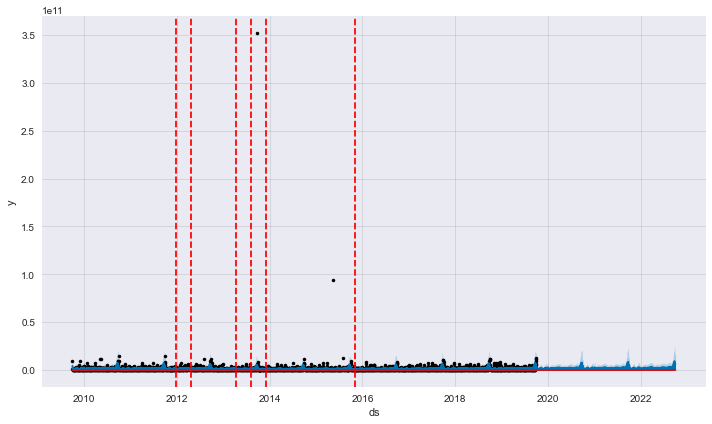

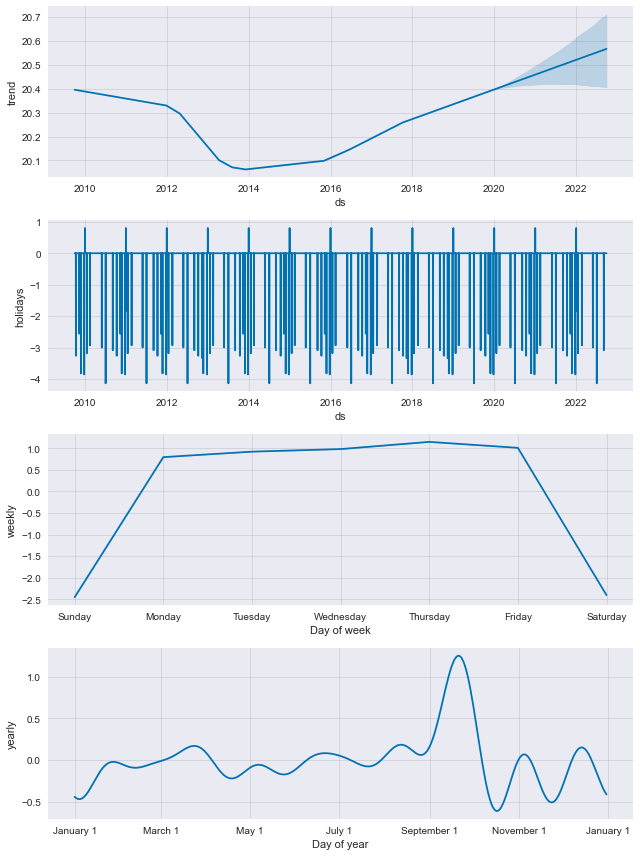

In [647]:
figure1, figure2 = Plot_Prophet_Model(model_Prophet, forecast)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

## The extreme outliers can be seen in the top graph

#### We will use df_without_outliers INSTEAD of df for the subsequent analysis

#### Compute Model again exluding the extreme outliers

In [648]:
%%time

df_for_modeling = df_without_outliers

selector = (df_for_modeling['action_date_fiscal_year'] != '2020') #make sure incomplete GFY 2020 is excluded since it is incomplete and we want to predict it
df_daily_total_obligations = Prepare_df_USAspending_for_Prophet(df_for_modeling[selector])

assert df_daily_total_obligations[-1:]['ds'].iloc[0] == '2019-09-30' #make sure incomplete GFY 2020 is excluded since it is incomplete and we want to predict it

model_Prophet, forecast = Build_Prophet_Model_forecast(df_daily_total_obligations, predict_days_in_the_future = (365 * 3))
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/Users/leifulstrup/opt/anaconda3/envs/FB_Prophet_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 59 s, sys: 4.77 s, total: 1min 3s
Wall time: 16 s


             ds          yhat    yhat_lower    yhat_upper
4742 2022-09-25  2.316479e+08  9.677703e+07  5.884028e+08
4743 2022-09-26  5.667453e+09  2.388787e+09  1.402961e+10
4744 2022-09-27  5.952454e+09  2.427342e+09  1.410627e+10
4745 2022-09-28  5.876821e+09  2.336944e+09  1.567829e+10
4746 2022-09-29  6.310571e+09  2.407567e+09  1.620666e+10


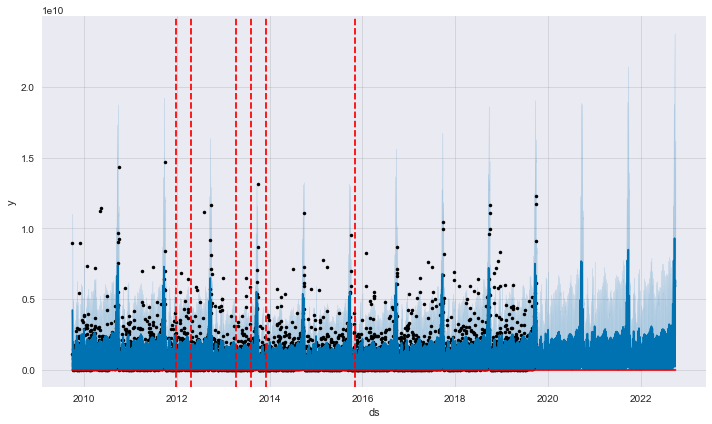

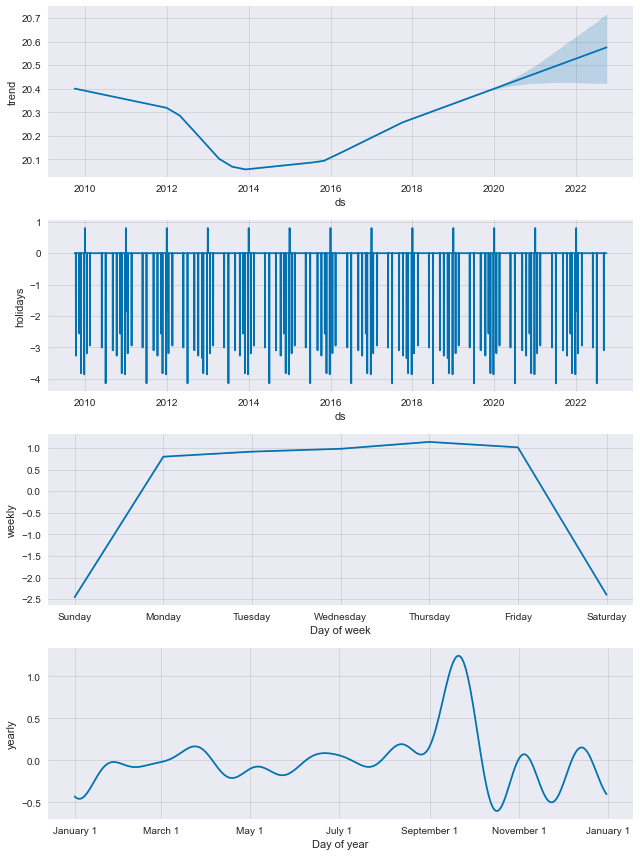

In [649]:
figure1, figure2 = Plot_Prophet_Model(model_Prophet, forecast)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Note: figure2 values are muted as np.log (natural log) - use np.exp to convert back
#Note: figure 1 values are in the predicted $ units, NOT np.log scaled

#### There may be some outliers left that are data entry mistakes (entry and backout), but the first graph now shows a richer model of the overall trends. Also, the red lines clearly demark major changes in the trajectory of the model.

### Explore Model Prediction Quality using the FB Prophet Cross Validation
#### https://en.wikipedia.org/wiki/Cross-validation_(statistics)

In [650]:
%%time
# reference Prophet's diagnostics documentation - https://facebook.github.io/prophet/docs/diagnostics.html
# see example of techniques for use of Prophet ccross validation here : https://xang1234.github.io/prophet/

# from Prophet documentation:
# "The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast 
#   values yhat, at each simulated forecast date and for each cutoff date. 
#   In particular, a forecast is made for every observed point between cutoff and cutoff + horizon. 
#   This dataframe can then be used to compute error measures of yhat vs. y."

from dask.distributed import Client

client = Client()  # connect to the cluster

# use V0.7 or higher to access the 'parallel' capability of Dask to speed model validation
# pre V0.7 version needs to have parallel removed

if DASK_INSTALLED:
    df_cv = cross_validation(model_Prophet, initial='730 days', period='180 days', horizon = '365 days', parallel="dask") #https://facebook.github.io/prophet/docs/diagnostics.html
else:
    df_cv = cross_validation(model_Prophet, initial='730 days', period='180 days', horizon = '365 days')
    
df_p = performance_metrics(df_cv)
df_p.head()

/Users/leifulstrup/opt/anaconda3/envs/FB_Prophet_env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64222 instead
  warnings.warn(
INFO:fbprophet:Making 15 forecasts with cutoffs between 2011-11-06 00:00:00 and 2018-09-30 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:64223' processes=4 threads=16, memory=68.72 GB>


CPU times: user 5.05 s, sys: 1.59 s, total: 6.64 s
Wall time: 28.7 s


,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,8.765324e+17,9.362331e+08,6.342404e+08,5.029120,0.632077,0.931136
1,38 days,8.196285e+17,9.053333e+08,6.181526e+08,4.905651,0.627752,0.934921
2,39 days,7.985992e+17,8.936438e+08,6.081710e+08,4.828592,0.613733,0.936752
3,40 days,7.778315e+17,8.819476e+08,6.049171e+08,4.849189,0.611253,0.937607
4,41 days,7.485798e+17,8.652050e+08,5.968560e+08,4.753066,0.619512,0.940476


In [651]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
5457,2019-09-26,4.962057e+09,3.489736e+09,6.346649e+09,9.110753e+09,2018-09-30
5458,2019-09-27,4.797824e+09,3.395731e+09,6.286173e+09,1.173926e+10,2018-09-30
5459,2019-09-28,2.813443e+09,1.365276e+09,4.185288e+09,1.813634e+09,2018-09-30
5460,2019-09-29,2.702048e+09,1.415819e+09,4.161595e+09,1.585347e+09,2018-09-30
5461,2019-09-30,4.062987e+09,2.627467e+09,5.405059e+09,1.231014e+10,2018-09-30


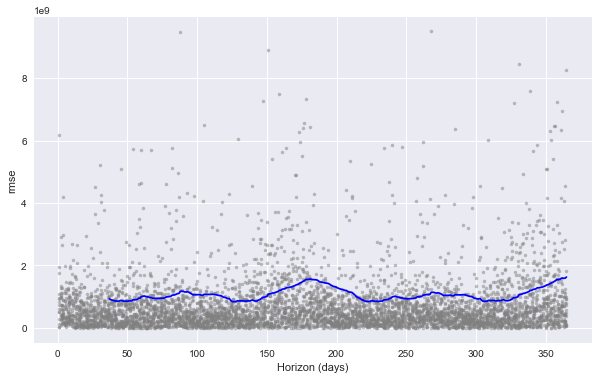

In [652]:
fig = plot_cross_validation_metric(df_cv, metric='rmse') # root mean square error

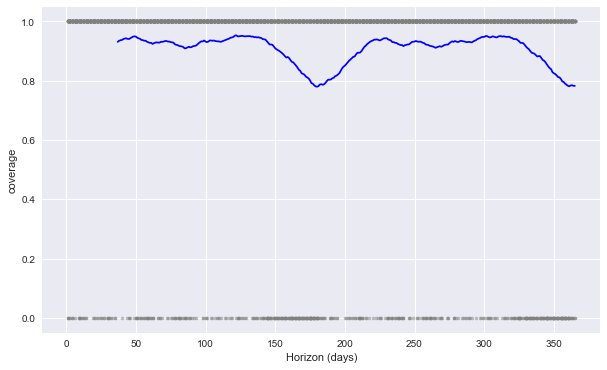

In [653]:
fig = plot_cross_validation_metric(df_cv, metric='coverage') # coverage of the real values vs the model (1.0 = 100%)

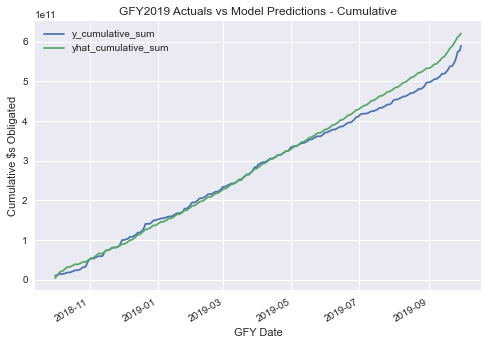

In [654]:
def plot_cumulative_sum_comparison(df_cv_original): # df_cv is the cross validation dataFrame Prophet produces using cross_validation
    df_cv = df_cv_original.tail(364).copy()
    df_cv['y_cumulative_sum'] = df_cv.tail(364)['y'].cumsum()
    df_cv['yhat_cumulative_sum'] = df_cv.tail(364)['yhat'].cumsum()
    gfy = getGFY(df_cv['ds'].iloc[0])
    figure = df_cv.plot(x='ds', y=['y_cumulative_sum', 'yhat_cumulative_sum'], title=f'GFY{gfy} Actuals vs Model Predictions - Cumulative')
    figure.set_ylabel("Cumulative $s Obligated")
    figure.set_xlabel("GFY Date")
    return figure, df_cv

figure_cumulative, df_cv_prediction_year = plot_cumulative_sum_comparison(df_cv)

In [655]:
df_cv_prediction_year.tail(1)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,y_cumulative_sum,yhat_cumulative_sum
5461,2019-09-30,4.062987e+09,2.627467e+09,5.405059e+09,1.231014e+10,2018-09-30,5.899008e+11,6.209608e+11


In [656]:
gfy = getGFY(df_cv_prediction_year['ds'].iloc[0])
gfy_actual_minus_prediction = float(df_cv_prediction_year.tail(1)['y_cumulative_sum'] - df_cv_prediction_year.tail(1)['yhat_cumulative_sum'])
print(f"GFY{gfy} Actual vs Predicted = ${round(gfy_actual_minus_prediction/1e9, 3)}B")

GFY2019 Actual vs Predicted = $-31.06B


In [657]:
obs_GFY2019_total_predicted = df_cv_prediction_year.tail(1)['yhat_cumulative_sum'].iloc[0]
obs_GFY2019_total_actual = df_cv_prediction_year.tail(1)['y_cumulative_sum'].iloc[0]
gfy_sum_fraction_predicted = obs_GFY2019_total_actual/obs_GFY2019_total_predicted
round(gfy_sum_fraction_predicted,3)

0.95

#### It would be interesting to explore DoD vs Civilian Agency Contracting predicted vs actual. Exercise for the reader! :-)

In [658]:
#(df['funding_agency_name'] == 'DEPARTMENT OF DEFENSE (DOD)') vs (df['funding_agency_name'] != 'DEPARTMENT OF DEFENSE (DOD)')

### What might be in store for the 2nd Half of GFY2020?

In [659]:
%%time
df_for_modeling = df # try this with the complete model including outliers

selector = (df_for_modeling['action_date_fiscal_year'] != '2021') #make sure incomplete GFY 2020 is excluded since it is incomplete and we want to predict it

# Prepare_df converts y values to np.log
df_daily_total_obligations = Prepare_df_USAspending_for_Prophet(df_for_modeling[selector])

CPU times: user 11.4 s, sys: 2.37 s, total: 13.8 s
Wall time: 14.5 s


/Users/leifulstrup/opt/anaconda3/envs/FB_Prophet_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [660]:
# Compute cumulate total for the 1st half of GFY2020
obs_GFY2020_H1_actual = df_daily_total_obligations.query("ds >= '2019-10-01' & ds < '2020-04-01'")['y'].apply(np.exp).sum() #need to apply np.exp to return values from np.log normalization
obs_GFY2020_H1_actual/1e9

328.35892707019985

In [661]:
obs_GFY2020_H2_predicted = forecast.query("ds >= '2020-04-01' & ds <'2020-10-01'")['yhat'].sum()
obs_GFY2020_H2_predicted/1e9

318.1577612479163

#### GFY2020 H1 Actuals + Prophet Model Predicted H2

In [662]:
obs_GFY2020_total_predicted = (obs_GFY20202_H1_actual + obs_GFY20202_H2_predicted)
obs_GFY2020_total_predicted/1e9

646.5166883181162

In [663]:
# predicted growth of GFY2020 contracting vs GFY2019
round(obs_GFY2020_total_predicted/obs_GFY2019_total_actual,3)

1.096

#### Shifting Analysis from the entire Federal spending to a specific Department

In [664]:
#sorted(df['funding_agency_name'].unique())

agency_name_analysis = 'DEPARTMENT OF HOMELAND SECURITY (DHS)'

In [665]:
selector = (df['funding_agency_name'] == agency_name_analysis) & (df['action_date_fiscal_year'] != '2020') #make sure incomplete GFY 2020 is excluded since it is incomplete and we want to predict it
df_daily_total_obligations = df[selector].groupby(['action_date'])['federal_action_obligation'].sum().reset_index()
df_daily_total_obligations.columns = ['ds', 'y'] # FB Prophet expects to see a DS column with dates and a Y column with the values

assert df_daily_total_obligations[-1:]['ds'].iloc[0] == '2019-09-30' #make sure incomplete GFY 2020 is excluded since it is incomplete and we want to predict it

df_daily_total_obligations.head()

model_Prophet = Prophet(holidays = df_holidays) # create an instance of the Prophet class
model_Prophet.add_country_holidays(country_name='US')
model_Prophet.fit(df_daily_total_obligations) # send the data to the model you created to fit the data

future = model_Prophet.make_future_dataframe(periods=365 * 2) # 2 year forecast
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
4349,2021-09-25
4350,2021-09-26
4351,2021-09-27
4352,2021-09-28
4353,2021-09-29


In [666]:
forecast = model_Prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4349,2021-09-25,1.221656e+08,4.851444e+07,1.953832e+08
4350,2021-09-26,1.170844e+08,4.846732e+07,1.913121e+08
4351,2021-09-27,1.566490e+08,8.231765e+07,2.256171e+08
4352,2021-09-28,1.604632e+08,9.018777e+07,2.350462e+08
4353,2021-09-29,1.569751e+08,8.392554e+07,2.312871e+08


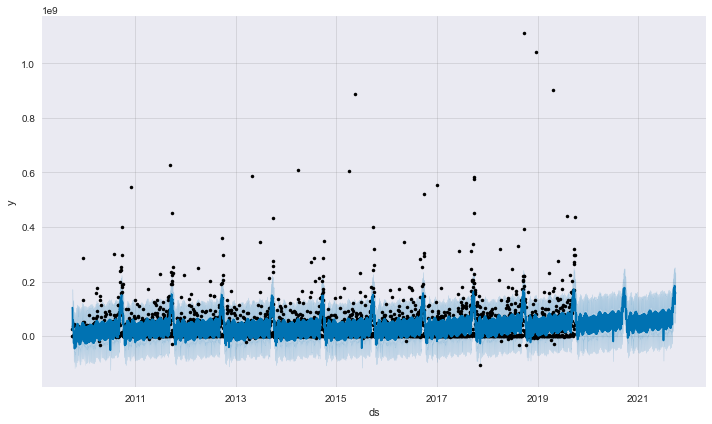

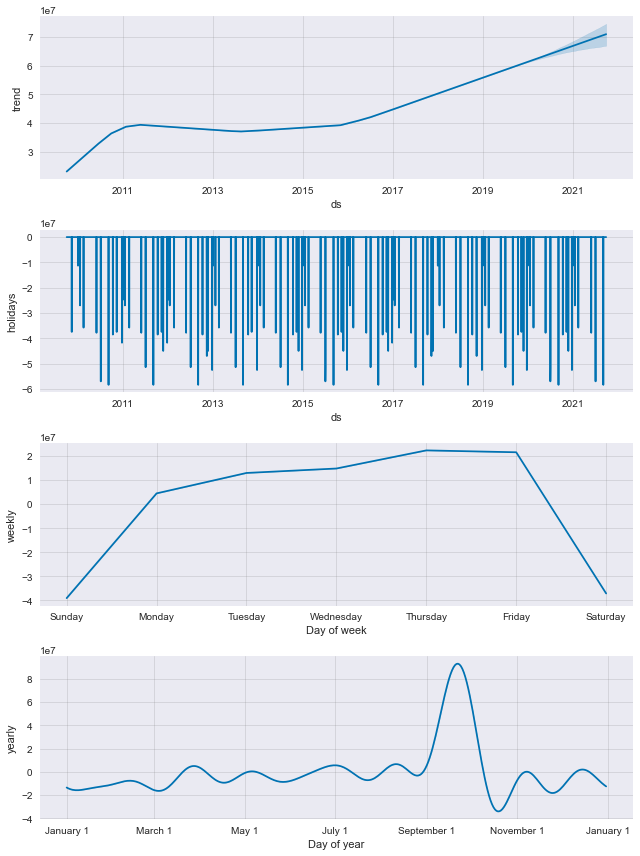

In [667]:
figure_1 = model_Prophet.plot(forecast)
figure_2 = model_Prophet.plot_components(forecast)

In [668]:
# Compute Sum of Actual Obligations through GFY2020 H1
selector = (df['funding_agency_name'] == agency_name_analysis) & (df['action_date'] >= '2019-10-01') & (df['action_date'] < '2020-04-01')
department_GFY20_H1_actual = df[selector]['federal_action_obligation'].sum()
department_GFY20_H1_actual

7056504664.56

In [669]:
# What does the Prophet Model predict for GFY2020 H1?
selector = (forecast['ds'] >= '2019-10-01') & (forecast['ds'] < '2020-04-01')
forecast[selector]['yhat'].sum()

9457219745.448563

In [670]:
# What does the model predict for GFY2020 for the Department?
selector = (forecast['ds'] >= '2019-10-01') & (forecast['ds'] < '2020-10-01')
department_GFY20_prediction = forecast[selector]['yhat'].sum()
department_GFY20_prediction

22555736970.397705

In [671]:
#GFY2020 H2 Prediction?
selector = (forecast['ds'] >= '2020-04-01') & (forecast['ds'] < '2020-10-01')
department_GFY20_H2_prediction = forecast[selector]['yhat'].sum()
department_GFY20_H2_prediction

13098517224.949139

In [672]:
department_GFY20_H1_actual + department_GFY20_H2_prediction

20155021889.50914

In [673]:
(department_GFY20_H1_actual + department_GFY20_H2_prediction)/department_GFY20_prediction

0.893565212077119

In [674]:
# Compute Sum of Actual Obligations for GFY2019
selector = (df['funding_agency_name'] == agency_name_analysis) & (df['action_date'] >= '2018-10-01') & (df['action_date'] < '2019-10-01')
department_GFY19_actual = df[selector]['federal_action_obligation'].sum()
department_GFY19_actual

19240101188.95

In [675]:
(department_GFY20_H1_actual + department_GFY20_H2_prediction)/department_GFY19_actual

1.047552800870122

In [676]:
department_GFY20_prediction/department_GFY19_actual

1.172329435738724

#### What might a Monte Carlo Simulation of the possible outcomes look like for FY2020 for this Department?

In [677]:
forecast_gfy20 = forecast.query("ds >= '2019-10-01' & ds < '2020-10-01'")[['ds','yhat','yhat_lower','yhat_upper']]
forecast_gfy20.head()

,ds,yhat,yhat_lower,yhat_upper
3624,2019-10-01,1.350234e+08,6.239664e+07,2.112839e+08
3625,2019-10-02,1.302233e+08,5.857292e+07,1.963951e+08
3626,2019-10-03,1.307443e+08,5.575412e+07,2.056672e+08
3627,2019-10-04,1.227042e+08,4.958086e+07,1.938230e+08
3628,2019-10-05,5.666341e+07,-1.667632e+07,1.325077e+08


In [678]:
def compute_obligation_sums_monte_carlo(forecast_gfy, simulation_runs = 1000, seed=12345, normal_distribution=True):
    random.seed(seed)
    gfy_obligation_sums = []
    Z_score = 1.959964
    for n in range(simulation_runs):
        if normal_distribution:
            forecast_gfy['random_choice'] = forecast_gfy.apply(lambda x: random.gauss(x['yhat'], (x['yhat_upper'] - x['yhat'])/Z_score), axis=1)
        else:
            forecast_gfy['random_choice'] = forecast_gfy.apply(lambda x: random.uniform(x['yhat_lower'], x['yhat_upper']), axis=1)
        gfy_obligation_sums.append(forecast_gfy['random_choice'].sum())
    return gfy_obligation_sums

In [679]:
%%time
gfy_obligation_sums = compute_obligation_sums_monte_carlo(forecast_gfy20)

CPU times: user 6.36 s, sys: 244 ms, total: 6.61 s
Wall time: 6.5 s


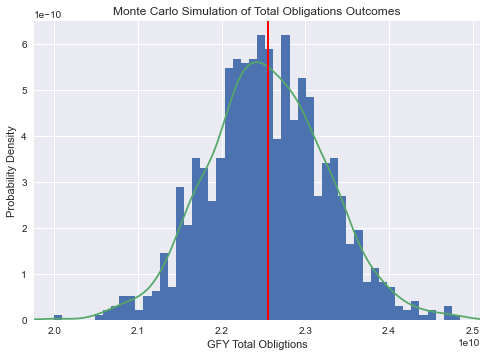

In [680]:
# example https://stackoverflow.com/questions/33203645/how-to-plot-a-histogram-using-matplotlib-in-python-with-a-list-of-data
import scipy.stats as st

def plot_monte_carlo_values_histogram(gfy_obligation_sums):
    histogram_array = plt.hist(gfy_obligation_sums, density=True, stacked=True, bins=50)

    mn, mx = plt.xlim()
    plt.xlim(mn, mx)
    kde_xs = np.linspace(mn, mx, 301)
    kde = st.gaussian_kde(gfy_obligation_sums)
    plt.plot(kde_xs, kde.pdf(kde_xs), label="Probability_Density_Function")

    plt.axvline(x=forecast_gfy20['yhat'].sum(), linewidth=2, color='r')
    value_returned = plt.ylabel("Probability Density")
    value_returned = plt.xlabel("GFY Total Obligtions")
    value_returned = plt.title("Monte Carlo Simulation of Total Obligations Outcomes")
    return 

plot_monte_carlo_values_histogram(gfy_obligation_sums)

### Shifting Analysis to the Patterns for the largest Federal contractor

In [681]:
df_contractors = df[df['action_date_fiscal_year']== '2019'].groupby(['recipient_parent_name'])['federal_action_obligation'].sum().reset_index().sort_values(by='federal_action_obligation', ascending=False)
df_contractors.head(10)

,recipient_parent_name,federal_action_obligation
62800,LOCKHEED MARTIN CORPORATION,4.953255e+10
102457,THE BOEING COMPANY,2.800522e+10
42675,GENERAL DYNAMICS CORPORATION,2.091186e+10
85721,RAYTHEON COMPANY,1.611537e+10
74852,NORTHROP GRUMMAN CORPORATION,1.599633e+10
66900,MCKESSON CORPORATION,9.640136e+09
107045,UNITED TECHNOLOGIES CORPORATION,8.205534e+09
50481,HUNTINGTON INGALLS INDUSTRIES INC.,7.606805e+09
61583,LEIDOS HOLDINGS INC.,7.297258e+09
50384,HUMANA INC.,6.804446e+09


In [682]:
recipient_rank = 5
recipient_parent_name_analysis = df_contractors['recipient_parent_name'].iloc[recipient_rank]
recipient_parent_name_analysis

'MCKESSON CORPORATION'

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


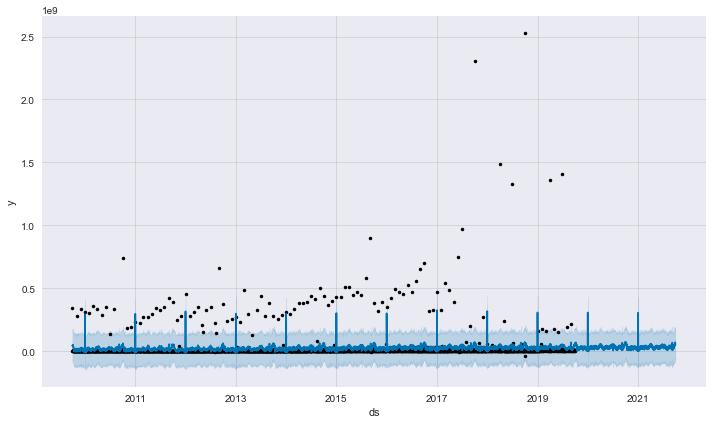

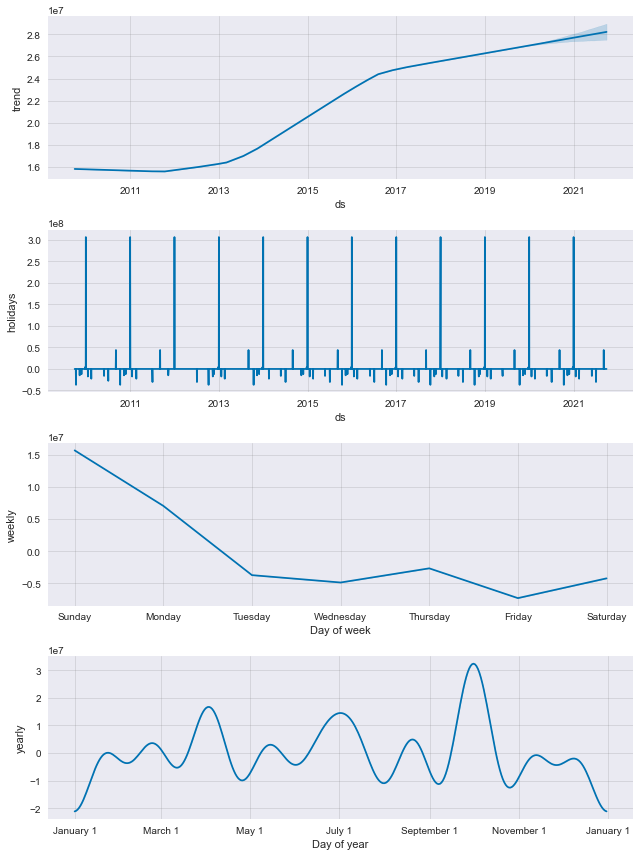

In [683]:
selector = (df['recipient_parent_name'] == recipient_parent_name_analysis) & (df['action_date_fiscal_year'] != '2020') #make sure incomplete GFY 2020 is excluded since it is incomplete and we want to predict it
df_daily_total_obligations = df[selector].groupby(['action_date'])['federal_action_obligation'].sum().reset_index()
df_daily_total_obligations.columns = ['ds', 'y'] # FB Prophet expects to see a DS column with dates and a Y column with the values

df_daily_total_obligations.head()

model_Prophet = Prophet(holidays = df_holidays) # create an instance of the Prophet class
model_Prophet.add_country_holidays(country_name='US')
model_Prophet.fit(df_daily_total_obligations) # send the data to the model you created to fit the data

future = model_Prophet.make_future_dataframe(periods=365 * 2) # 2 year forecast
future.tail()

forecast = model_Prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

figure_1 = model_Prophet.plot(forecast)
figure_2 = model_Prophet.plot_components(forecast)

In [684]:
### Projecting FY2020 (ending 9/30/20) Total Obligations

In [685]:
selector = (forecast['ds'] >= '2019-10-01') & (forecast['ds'] < '2020-10-01')
forecast[selector]['yhat'].sum()

10131993258.181202

In [686]:
# Predicted GFY2020/GFY2019
forecast[selector]['yhat'].sum()/df_contractors.iloc[recipient_rank]['federal_action_obligation']

1.0510218317972015

In [687]:
df_company_total_obligations = df[df['recipient_parent_name'] == recipient_parent_name_analysis].groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().reset_index()[:-1]
df_company_total_obligations

,action_date_fiscal_year,federal_action_obligation
0,2010,4.603574e+09
1,2011,4.702248e+09
2,2012,4.662284e+09
3,2013,4.729336e+09
4,2014,6.205380e+09
5,2015,8.352965e+09
6,2016,8.635689e+09
7,2017,8.800462e+09
8,2018,8.965204e+09
9,2019,9.640136e+09


In [688]:
def cagr(starting_amount, ending_amount, years):
    return -1 + (ending_amount/starting_amount)**(1/years)

cagr(df_company_total_obligations['federal_action_obligation'].iloc[-4], df_company_total_obligations['federal_action_obligation'].iloc[-1], 3)

0.03735815910938722

#### What might a Monte Carlo Simulation of the possible outcomes look like for FY2020 for this Company?

In [689]:
forecast_gfy20 = forecast.query("ds >= '2019-10-01' & ds < '2020-10-01'")[['ds','yhat','yhat_lower','yhat_upper']]
forecast_gfy20.head()

,ds,yhat,yhat_lower,yhat_upper
3340,2019-10-01,5.542299e+07,-8.026765e+07,1.762800e+08
3341,2019-10-02,5.425766e+07,-6.830842e+07,1.821610e+08
3342,2019-10-03,5.602289e+07,-7.144475e+07,1.755710e+08
3343,2019-10-04,5.057382e+07,-7.389814e+07,1.889746e+08
3344,2019-10-05,5.242387e+07,-7.110658e+07,1.751027e+08


In [690]:
%%time
gfy_obligation_sums = compute_obligation_sums_monte_carlo(forecast_gfy20)

CPU times: user 7.17 s, sys: 271 ms, total: 7.44 s
Wall time: 7.3 s


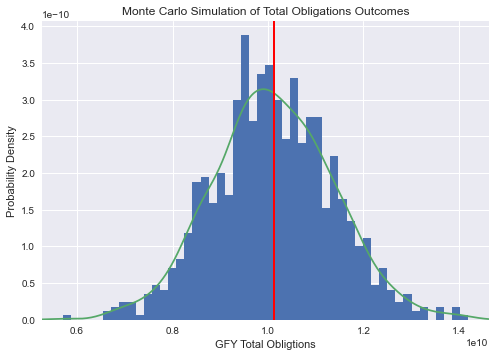

In [691]:
plot_monte_carlo_values_histogram(gfy_obligation_sums)

### Switch to the #2 Company

In [692]:
recipient_rank = 9
recipient_parent_name_analysis = df_contractors['recipient_parent_name'].iloc[recipient_rank]
recipient_parent_name_analysis

'HUMANA INC.'

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


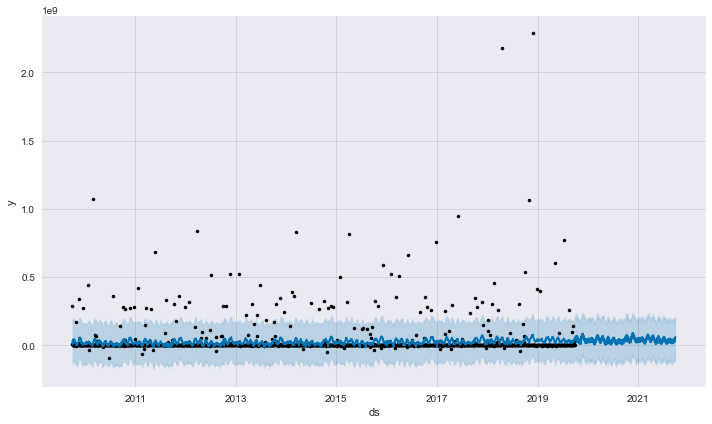

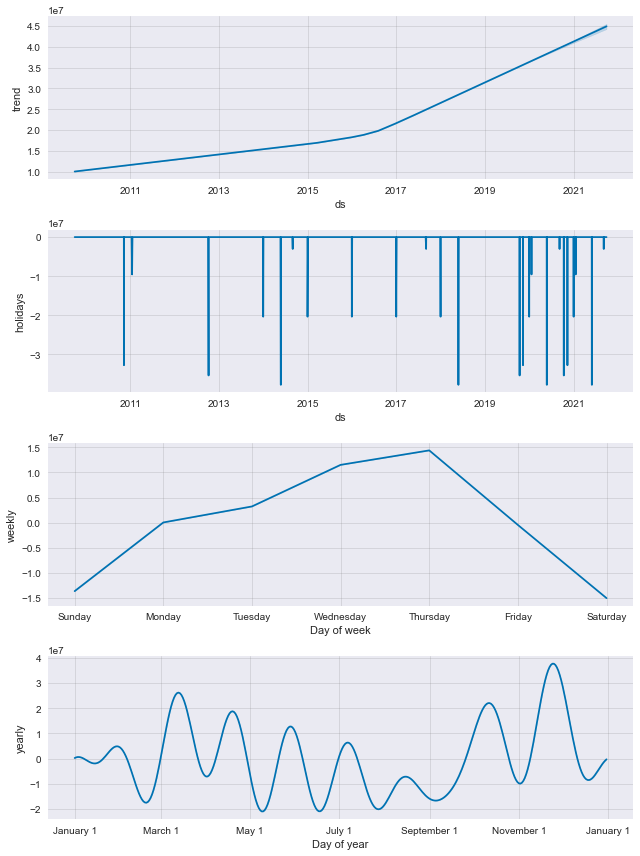

In [693]:
selector = (df['recipient_parent_name'] == recipient_parent_name_analysis) & (df['action_date_fiscal_year'] != '2020') #make sure incomplete GFY 2020 is excluded since it is incomplete and we want to predict it
df_daily_total_obligations = df[selector].groupby(['action_date'])['federal_action_obligation'].sum().reset_index()
df_daily_total_obligations.columns = ['ds', 'y'] # FB Prophet expects to see a DS column with dates and a Y column with the values

df_daily_total_obligations.head()

model_Prophet = Prophet(holidays = df_holidays) # create an instance of the Prophet class
model_Prophet.add_country_holidays(country_name='US')
model_Prophet.fit(df_daily_total_obligations) # send the data to the model you created to fit the data

future = model_Prophet.make_future_dataframe(periods=365 * 2) # 2 year forecast
future.tail()

forecast = model_Prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

figure_1 = model_Prophet.plot(forecast)

figure_2 = model_Prophet.plot_components(forecast)

In [694]:
### Projecting FY2020 (ending 9/30/20) Total Obligations

selector = (forecast['ds'] >= '2019-10-01') & (forecast['ds'] < '2020-10-01')
forecast[selector]['yhat'].sum()

13635531066.214842

In [695]:
# Predicted GFY2020/GFY2019
forecast[selector]['yhat'].sum()/df_contractors.iloc[recipient_rank]['federal_action_obligation']

2.003915047433609

In [696]:
df_company_total_obligations = df[df['recipient_parent_name'] == recipient_parent_name_analysis].groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().reset_index()[:-1]
df_company_total_obligations

,action_date_fiscal_year,federal_action_obligation
0,2010,3.248678e+09
1,2011,3.445751e+09
2,2012,3.472046e+09
3,2013,3.495894e+09
4,2014,3.586782e+09
5,2015,3.607461e+09
6,2016,3.651448e+09
7,2017,3.715287e+09
8,2018,5.473004e+09
9,2019,6.804446e+09


In [697]:
# def cagr(starting_amount, ending_amount, years):
#     return -1 + (ending_amount/starting_amount)**(1/years)

cagr(df_company_total_obligations['federal_action_obligation'].iloc[-4], df_company_total_obligations['federal_action_obligation'].iloc[-1], 3)

0.23057821859165606

### Random Selection of a Company with Greater Than $250m in Obligations

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


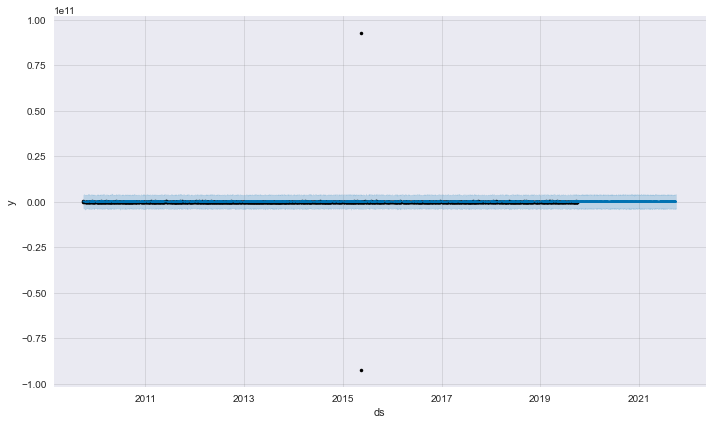

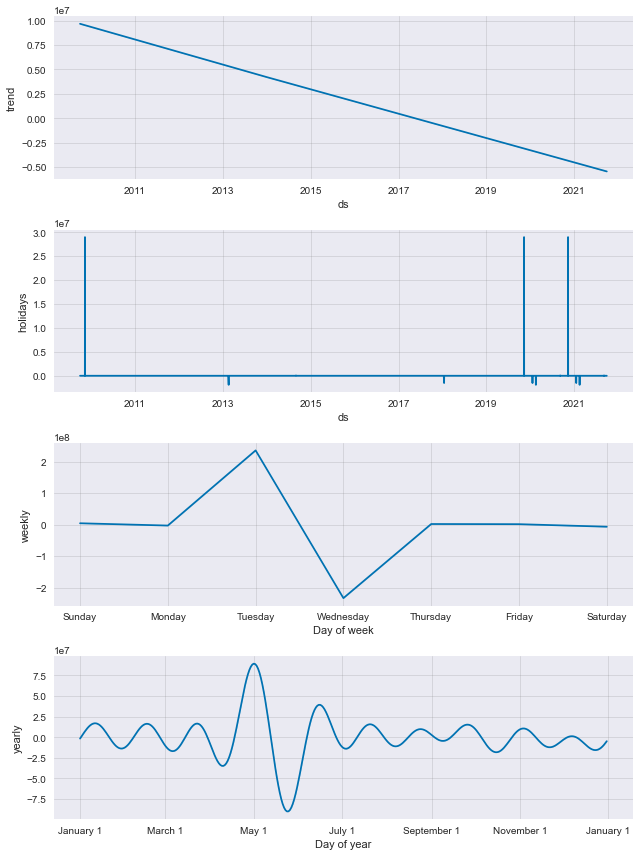

In [698]:
recipient_parent_name_analysis = df_contractors[df_contractors['federal_action_obligation'] > 250e6].sample(n=1)['recipient_parent_name'].iloc[0]

selector = (df['recipient_parent_name'] == recipient_parent_name_analysis) & (df['action_date_fiscal_year'] != '2020') #make sure incomplete GFY 2020 is excluded since it is incomplete and we want to predict it
df_daily_total_obligations = df[selector].groupby(['action_date'])['federal_action_obligation'].sum().reset_index()
df_daily_total_obligations.columns = ['ds', 'y'] # FB Prophet expects to see a DS column with dates and a Y column with the values

df_daily_total_obligations.head()

model_Prophet = Prophet(holidays = df_holidays) # create an instance of the Prophet class
model_Prophet.add_country_holidays(country_name='US')
model_Prophet.fit(df_daily_total_obligations) # send the data to the model you created to fit the data

future = model_Prophet.make_future_dataframe(periods=365 * 2) # 2 year forecast
future.tail()

forecast = model_Prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

figure_1 = model_Prophet.plot(forecast)

figure_2 = model_Prophet.plot_components(forecast)

In [699]:
recipient_parent_name_analysis

'HENSEL PHELPS CONSTRUCTION CO'

### End

#### https://opensource.org/licenses/MIT

#### MIT Open Source License Copyright 2020 Leif C Ulstrup

#### Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

#### The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

#### THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.